# W4671 Final Project

## Using DNABert to Improve Microbiome Representations for  Distinguish Patients with Clostridium difficile Infection and Non-C. difficile-Associated Diarrhea from Healthy Controls

## George Austin, gia2105

### Data Setup

In [1]:
# setups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering as AC



### DNABERT stuff
import sys
sys.path.append("../DNABERT/examples/data_process_template")
sys.path.append("../DNABERT/examples/")
sys.path.append("../DNABERT/src")
import process_690
import run_pretrain
import run_finetune

### Dataset stuff

#### pulling the reads
kmer = 6
reads_path = '../MicrobiomeHD_data/cdi_schubert_results/cdi_schubert.otu_seqs.dbOTU.fasta'
reads_ = pd.read_csv(reads_path, sep = ',', header = None)


# for the first reads_path
reads = pd.DataFrame(\
 {'label':reads_.iloc[range(reads_.shape[0])[::2]].reset_index()[0] ,\
  'elements':reads_.iloc[range(reads_.shape[0])[1::2]].reset_index()[0]
  })
reads['label'] = reads.label.str[1:]


## getting data in the right format for DNAbert
def kmerify(row):
    return(process_690.get_kmer_sentence( row.elements, kmer=6))


reads['kmers'] = reads.apply( kmerify, axis = 1 )


## setting up DNABert model
import argparse
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple
from copy import deepcopy
from multiprocessing import Pool

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

# a lot of this code is from DNABert's repo
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertModel,
    BertConfig,
    BertForMaskedLM,
    BertTokenizer,
    DNATokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

MODEL_CLASSES = {
    "gpt2": (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    "openai-gpt": (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    "dna": (BertConfig, BertForMaskedLM, DNATokenizer),
    "bert": (BertConfig, BertForMaskedLM, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForMaskedLM, CamembertTokenizer),
}


## standard code for loading pretrained huggingface model
config_class, model_class, tokenizer_class = MODEL_CLASSES['dna']

config = config_class.from_pretrained('../DNABERT_model_6/',\
                                      cache_dir='cache/')
config.output_hidden_states = True

tokenizer = tokenizer_class.from_pretrained('../DNABERT_model_6/',\
                                cache_dir='cache/')

model = BertModel.from_pretrained(  '../DNABERT_model_6',
            cache_dir= 'cache/',
            config = config)

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
%%time
## creating the reads -- using sbert-wk implementation
import imp
from sbert_wk_functions import create_embeddings, generate_embedding

embeddings = create_embeddings(list(reads.kmers), model, tokenizer, use_sbert = True)

reads['idx'] = reads.index

# 3 minutes/800 reads -- pretty good tim

CPU times: user 3min 18s, sys: 9.13 s, total: 3min 27s
Wall time: 3min 18s


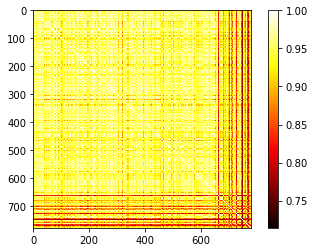

In [3]:
n = len(embeddings)
sims = np.zeros((n, n))

#getting cosine similarities -- theres probably a good function for this...
for i in range(n):
    for j in range(i, n):
        sims[i,j] = embeddings[i].dot(embeddings[j])/ \
                    (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))

sims = sims + sims.T - np.eye(sims.shape[0])

#visualizing similarity matrix
plt.imshow(sims, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

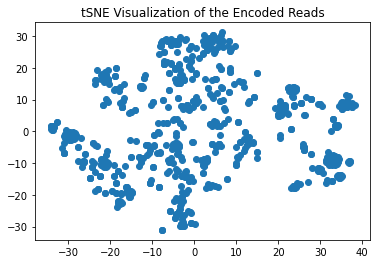

In [5]:
#visualizing representations of the reads
pc = PCA(n_components = 100)
ts = TSNE(n_components = 2, perplexity = 30)

viz = ts.fit_transform( pc.fit_transform(embeddings) )
plt.scatter(viz[:,0], viz[:, 1])
plt.title('tSNE Visualization of the Encoded Reads')
plt.show()

In [6]:
# reading/set up the otu abundance matrix
path = '../MicrobiomeHD_data/cdi_schubert_results/cdi_schubert.otu_table.dbOTU'

df = pd.read_csv(path, sep = '\t')
df.index = df[df.columns[0]]
df_fixed = df.drop(df.columns[0], axis = 1).transpose()
df_fixed = df_fixed.div(df_fixed.sum(axis=1), axis=0)
df_fixed = df_fixed[list( df_fixed.columns.dropna() )]
df_fixed = df_fixed[[a for a in reads.label]]
df_fixed.head()

Unnamed: 0,dbotu8913,dbotu7799,dbotu7248,dbotu4478,dbotu7781,dbotu14876,dbotu13118,dbotu18794,dbotu18855,dbotu1345,...,dbotu15656,dbotu15978,dbotu16521,dbotu16531,dbotu17330,dbotu17429,dbotu17572,dbotu18353,dbotu18953,dbotu19580
DA00006,0.000000,0.277059,0.081007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DA00044,0.001038,0.000000,0.645898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DA00065,0.263246,0.001677,0.000000,0.203219,0.168343,0.184105,0.000000,0.028840,0.000000,0.000671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DA00108,0.267123,0.503044,0.000000,0.000761,0.000000,0.002283,0.012938,0.008752,0.003425,0.018265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DA00153,0.006797,0.000400,0.005598,0.023591,0.013195,0.008796,0.000400,0.003199,0.041184,0.006797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# set up prediction task
metadata_path = '../MicrobiomeHD_data/cdi_schubert_results/cdi_schubert.metadata.txt'

metadata = pd.read_csv(metadata_path, sep = '\t', encoding = 'latin1')

metadata['Var'] = metadata.biome
metadata['#Sample ID'] = metadata.sample_id
metadata = metadata[['#Sample ID', 'Var']]
metadata.head()

,#Sample ID,Var
0,DA00006,hospital
1,DA00044,hospital
2,DA00065,hospital
3,DA00108,hospital
4,DA00153,hospital


In [25]:
def test_reduced_dims(df_fixed, response, embeddings, n_dims, names):
    """
    reduces the dimensions by aggregating based on cluster similarity
    """
    cm = AC(n_clusters = n_dims, affinity = 'cosine', linkage='average')
    cm.fit(embeddings)
    names['cluster'] = cm.labels_
    
    reduced = df_fixed.copy()
    reduced.columns = names.cluster
    #reduced = reduced.transpose().groupby('cluster').sum().transpose()
    red = reduced.transpose()
    reduced = red.groupby(red.index).sum().transpose()

    reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

    X = reduced_resp.drop('Var', axis = 1)
    #taking the less common class as the positive response
    y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]
    
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        try:
            y_train, y_test = y[train_index], y[test_index]
        except:
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #rf = RandomForestClassifier(n_estimators = 100)
        rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )
        
    
    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)
        
    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)
        
    return(fpr, tpr, auc_val, n_dims)

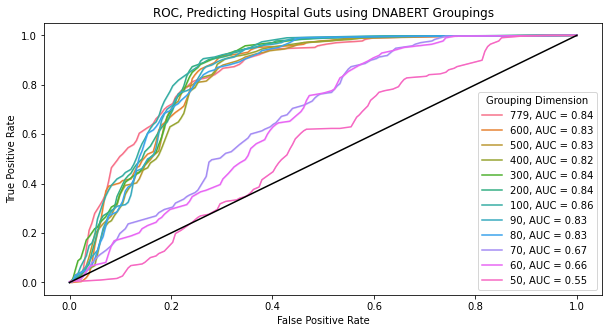

In [29]:
#show performance of DNABert hierarchal clustering
L = []

for i in [df_fixed.shape[1], 600, 500, 400, 300, 200, 100, 90, 80, 70, 60, 50]:
    L.append( test_reduced_dims(df_fixed, metadata, embeddings, i, reads) )

full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \
                        + full_results.auc.astype(str).str[0:4]

import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = full_results,\
             ci= 0, hue = 'Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Hospital Guts using DNABERT Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [17]:
# Mapping clusters to phylogeny, exploring the cases where the clusters differ,
# and how it relates to interpretable signals from logistic regression

phylos = pd.read_csv('../MicrobiomeHD_data/cdi_schubert_results/RDP/cdi_schubert.otu_table.dbOTU.rdp_assigned', sep = '\t')['Unnamed: 0']

otu_phylo = pd.DataFrame( \
        dict( {'otu':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[-1], 
        'phylogeny':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[:-1].str.join(' ') } ) 
          )

# taking dimension of 100, consistently giving good results
clusterer = AC(n_clusters=100, linkage="average", affinity='cosine')
clusterer.fit(embeddings)
reads['cluster'] = clusterer.labels_

merged_info = otu_phylo.merge(reads, how = 'inner', left_on = 'otu', right_on = 'label')[['otu', 'phylogeny', 'cluster']]


reduced = df_fixed.copy()
reduced.columns = reads.cluster
red = reduced.transpose()
reduced = red.groupby(red.index).sum().transpose()

response = metadata
reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

PREDS = []
TRUES = []

kf = KFold(n_splits=5, random_state=None, shuffle=True)
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

cluster_summaries = merged_info.groupby('cluster')['phylogeny'].agg(lambda x: dict(x.value_counts())).reset_index()

cluster_summaries['coef'] = rf.coef_[0]

# observing the clusters corresponding to significant coefficients
for i in cluster_summaries.loc[cluster_summaries.coef != 0].index:
    print(cluster_summaries.phylogeny[i])
    print(cluster_summaries.coef[i])

{' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae': 21, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Blautia': 10, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Ruminococcus2': 8, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Roseburia': 5, ' Bacteria Firmicutes Clostridia Clostridiales': 4, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Coprococcus': 3, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Clostridiu XlVa': 2, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Lachnospirace incerta sedis': 2, ' Bacteria Firmicutes Erysipelotrichia Erysipelotrichales Erysipelotrichaceae Catenibacterium': 1, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Anaerostipes': 1}
-0.857986334890996
{' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae': 8, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Clostridiu XlVa': 4, ' Bacteria Firmicutes Clostri

In [27]:
# exploring logistic regression results when grouping by phylogenetic assignment
def test_reduce_by_phylo_name(df_fixed, response, n_cutoffs,  names):
    cluster = names.phylogeny.str.split(' ').str[:n_cutoffs].str.join(' ')


    reduced = df_fixed.copy()
    reduced.columns = cluster
    reduced = reduced.transpose().groupby('phylogeny').sum().transpose()
    reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

    X = reduced_resp.drop('Var', axis = 1)

    #taking the less common class as the positive response
    y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

    #doing K-Fold cross validation, to get 100+ predictions

    #     X_train, X_test, y_train, y_test = train_test_split(\
    #                         X, y, test_size=0.15, random_state=42)
    
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #rf = RandomForestClassifier(n_estimators = 100)
        rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )

    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)

    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)

    return(fpr, tpr, auc_val, X.shape[1] )

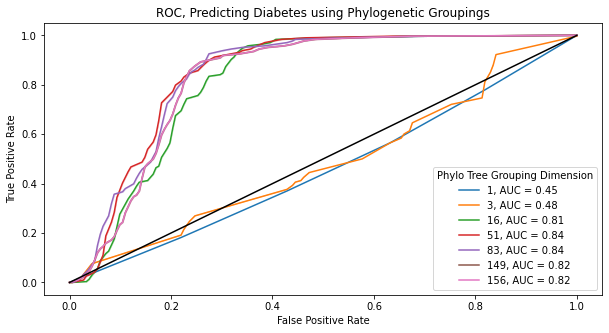

In [28]:
G = []
for i in [1, 2, 3, 5, 6, 7, 20]:
    G.append( test_reduce_by_phylo_name(df_fixed, response, i, otu_phylo) )
    
    
phylo_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_cutoffs':[a[3]]*len(a[1]) } ) \
           for a in G ], axis = 0 )

phylo_results['Phylo Tree Grouping Dimension'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                        + phylo_results.auc.astype(str).str[0:4]


plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = phylo_results,\
             ci= 0, hue = 'Phylo Tree Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Hospital Guts using Phylogenetic Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Some observations:
- 156 is the number of distinct phylogenetic assignments in the dataset
- When reducing by phylogenetic, we are generally doing worse when working in dimensions > 100. There is a point where when we are in small enough dimensions, there are stronger signals in the phylo reduced
- We don't have much programmatic control over the dimensions we group to when using phylogenetic tree
- Our grouping frmo reads does put the same phylogenies in different groups with opposing coefficients. This flexibility is leading to improved performance.
- the pre-trained DNABert model has not been fine-tuned for any task close to this. I would expect we can get significant improvements in performance from this clustering approach with a fine-tuned model. (this would come with it's own set of challenges, especially collecting the microbiome data)

In [20]:
n_cutoffs = 6
cluster = merged_info.phylogeny.str.split(' ').str[:n_cutoffs].str.join(' ')

reduced = df_fixed.copy()
reduced.columns = cluster
reduced = reduced.transpose().groupby('phylogeny').sum().transpose()
reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
print(n_cutoffs, X.shape)
#taking the less common class as the positive response
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

phylo_group_results = pd.DataFrame(dict({ 'phylo':reduced.columns, 
                     'coef':rf.coef_[0] }))

for i in phylo_group_results.loc[phylo_group_results.coef != 0].index:
    print(phylo_group_results.phylo[i])
    print(phylo_group_results.coef[i])

# #rf.coef_

# for i in cluster_summaries.loc[cluster_summaries.coef != 0].index:
#     print(cluster_summaries.phylogeny[i])
#     print(cluster_summaries.coef[i])

6 (336, 83)
 Bacteria Bacteroidetes Bacteroidia Bacteroidales Bacteroidaceae
2.229547879139853
 Bacteria Bacteroidetes Bacteroidia Bacteroidales Prevotellaceae
2.730428296121387
 Bacteria Firmicutes Bacilli Lactobacillales Enterococcaceae
-7.220737419176444
 Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae
-1.869106687098278
 Bacteria Firmicutes Negativicutes Selenomonadales Veillonellaceae
0.0883943497006244
 Bacteria Proteobacteria Gammaproteobacteria Enterobacteriales Enterobacteriaceae
-4.502495548875705
 Bacteria Verrucomicrobia Verrucomicrobiae Verrucomicrobiales Verrucomicrobiaceae
-0.9220894351822131


## to-dos:
- organize this work on predicting hospital guts into a notebook (it is pretty interesting) DONE
- read more about the study where this study is coming from DONE
- find 1-2 more studies where I can dive into the results
- potentially investigate the groupings using embeddings based on the phylogenetic names. (look into how the results change if we remove a few elements from each clust)
- focus on the areas where the phylogenetic assignment isn't enough. the differing signals in coefficient + same phylo is very relevant for this project